# Part 5: Interpretability & Diagnostic Evaluation

This notebook analyzes the trained Transformer model from Q3 using saliency maps for input importance and entropy for uncertainty estimation. We evaluate 5 failure cases to understand model limitations.

## 1. Imports & Model Architecture

Define the Transformer model architecture (PositionalEncoding, TransformerModel) identical to Q3 for loading saved weights.

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from transformers import DistilBertModel, DistilBertTokenizer


sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")



class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, output_dim, emb_dim, nhead, hid_dim, n_layers, dropout, device):
        super().__init__()
        self.device = device
        self.emb_dim = emb_dim

        # 1. Encoder Projection (BERT Vectors -> Model Dim)
        self.bert_proj = nn.Linear(768, emb_dim)

        # 2. Decoder Embedding
        self.trg_embedding = nn.Embedding(output_dim, emb_dim)

        # 3. Components
        self.pos_encoder = PositionalEncoding(emb_dim, dropout)

        self.transformer = nn.Transformer(
            d_model=emb_dim,
            nhead=nhead,
            num_encoder_layers=n_layers,
            num_decoder_layers=n_layers,
            dim_feedforward=hid_dim,
            dropout=dropout,
            batch_first=True
        )

        self.fc_out = nn.Linear(emb_dim, output_dim)

    def make_trg_mask(self, trg):
        length = trg.shape[1]
        mask = torch.triu(torch.ones(length, length) * float('-inf'), diagonal=1)
        return mask.to(self.device)

    def forward(self, src, trg, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # src: [Batch, Seq, 768]
        # trg: [Batch, Seq]
        # --- Projection & Positional Encoding ---
        src_emb = self.pos_encoder(self.bert_proj(src))
        trg_emb = self.pos_encoder(self.trg_embedding(trg) * math.sqrt(self.emb_dim))

        # --- Transformer Forward Pass ---
        output = self.transformer(
            src=src_emb,
            tgt=trg_emb,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_pad_mask,
            tgt_key_padding_mask=tgt_pad_mask,
            memory_key_padding_mask=src_pad_mask
        )

        return self.fc_out(output)

# --- MASK GENERATION HELPER ---
def batch_mask_factory(src_vectors, trg_tokens, device):
    """Generates all necessary masks for the Transformer."""
    # 1. Target Look-Ahead Mask (Causal)
    sz = trg_tokens.size(1)
    tgt_mask = torch.triu(torch.ones(sz, sz, device=device) * float('-inf'), diagonal=1)

    # 2. Source Padding Mask
    src_pad_mask = (src_vectors.abs().sum(dim=-1) == 0)

    # 3. Target Padding Mask
    tgt_pad_mask = (trg_tokens == 0)  # PAD_IDX = 0

    return tgt_mask, src_pad_mask, tgt_pad_mask

print("✅ Model architecture defined.")


Device: cuda
✅ Model architecture defined.


## 2. Load Models

Load DistilBERT tokenizers and encoder, initialize Transformer with Q3 hyperparameters, and load saved weights from `transformer_model_final.pt`.

In [2]:

print("\n1. Loading DistilBERT for Inference Analysis...")
# Tokenizers
tokenizer_src = DistilBertTokenizer.from_pretrained('distilbert-base-german-cased')
tokenizer_trg = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
PAD_IDX = tokenizer_src.pad_token_id
VOCAB_SIZE_TRG = tokenizer_trg.vocab_size

# BERT Model
bert_model_inference = DistilBertModel.from_pretrained('distilbert-base-german-cased').to(device)
bert_model_inference.eval()

print("2. Initializing Transformer Model Architecture...")
# Model hyperparameters (same as Q3)
HID_DIM = 256
ENC_LAYERS = 2
HEADS = 8
FF_DIM = 512
DROPOUT = 0.1

# Create model
model_trans = TransformerModel(
    output_dim=VOCAB_SIZE_TRG,
    emb_dim=HID_DIM,
    nhead=HEADS,
    hid_dim=FF_DIM,
    n_layers=ENC_LAYERS,
    dropout=DROPOUT,
    device=device
).to(device)

print("3. Loading Saved Transformer Model ('transformer_model_final.pt')...")
try:
    checkpoint = torch.load('transformer_model_final.pt', map_location=device)
    # Load from checkpoint format
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model_trans.load_state_dict(checkpoint['model_state_dict'])
        print(f"✅ SUCCESS: Loaded from checkpoint (Epoch {checkpoint.get('epoch', '?')}, Loss: {checkpoint.get('loss', '?'):.4f})")
    else:
        # Direct state_dict format
        model_trans.load_state_dict(checkpoint)
        print("✅ SUCCESS: Best model weights loaded successfully!")
except FileNotFoundError:
    print("⚠️ WARNING: 'transformer_model_final.pt' not found! Using random weights.")
except Exception as e:
    print(f"❌ ERROR: Could not load model. Error: {e}")
    
model_trans.eval()



1. Loading DistilBERT for Inference Analysis...
2. Initializing Transformer Model Architecture...
3. Loading Best Saved Transformer Model ('transformer_model_final.pt')...
2. Initializing Transformer Model Architecture...
3. Loading Best Saved Transformer Model ('transformer_model_final.pt')...


C:\Users\ali19\AppData\Local\Temp\ipykernel_23996\3344028297.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('transformer_model_final.pt', map_l

✅ SUCCESS: Loaded from checkpoint (Epoch 5, Loss: 1.5458)


TransformerModel(
  (bert_proj): Linear(in_features=768, out_features=256, bias=True)
  (trg_embedding): Embedding(30522, 256)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((2

## 3. Analysis Function (Saliency & Entropy)

`analyze_prediction()` generates translations using greedy decoding, computes gradient-based saliency maps for input importance, and calculates entropy for uncertainty estimation.

In [10]:
def analyze_prediction(sentence, model_trans, bert_model, tokenizer_src, tokenizer_trg, device, max_len=50):
    """Generate translation with saliency maps and entropy analysis."""
    model_trans.eval()
    
    # Get BERT embeddings
    inputs = tokenizer_src(sentence, return_tensors='pt', padding=True, truncation=True).to(device)
    
    with torch.no_grad():
        bert_output = bert_model(**inputs).last_hidden_state  # [1, Seq, 768]
    
    # Enable gradient tracking for saliency
    src_vectors = bert_output.clone().detach().requires_grad_(True)
    
    # Decoding loop
    bos_token_id = tokenizer_trg.cls_token_id
    eos_token_id = tokenizer_trg.sep_token_id
    
    trg_indexes = [bos_token_id]
    generated_tokens = []
    uncertainties = []
    recent_tokens = []
    
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes]).to(device)
        
        # Create masks
        t_mask, s_pad, t_pad = batch_mask_factory(src_vectors, trg_tensor, device)
        
        # Forward pass
        with torch.enable_grad():
            output = model_trans(src_vectors, trg_tensor, tgt_mask=t_mask, src_pad_mask=s_pad, tgt_pad_mask=t_pad)
        
        # Get logits for last token
        last_token_logits = output[0, -1, :].clone()
        
        # Repetition penalty
        for prev_token in recent_tokens[-3:]:
            last_token_logits[prev_token] -= 2.0
        
        # Uncertainty (Entropy)
        probs = F.softmax(last_token_logits, dim=0)
        entropy = -torch.sum(probs * torch.log(probs + 1e-9)).item()
        uncertainties.append(entropy)
        
        # Greedy prediction
        pred_token_id = last_token_logits.argmax().item()
        
        # Stop if same token repeated 3 times
        if len(recent_tokens) >= 2 and all(t == pred_token_id for t in recent_tokens[-2:]):
            break
            
        trg_indexes.append(pred_token_id)
        recent_tokens.append(pred_token_id)
        
        token_str = tokenizer_trg.decode([pred_token_id])
        generated_tokens.append(token_str)
        
        # Stop at EOS
        if pred_token_id == eos_token_id or pred_token_id == tokenizer_trg.pad_token_id:
            break
    
    # Compute saliency map via gradient backprop
    if len(generated_tokens) > 0:
        final_output = model_trans(src_vectors, torch.LongTensor([trg_indexes]).to(device), 
                                    tgt_mask=batch_mask_factory(src_vectors, torch.LongTensor([trg_indexes]).to(device), device)[0],
                                    src_pad_mask=batch_mask_factory(src_vectors, torch.LongTensor([trg_indexes]).to(device), device)[1],
                                    tgt_pad_mask=batch_mask_factory(src_vectors, torch.LongTensor([trg_indexes]).to(device), device)[2])
        score = final_output[0, -1, :].max()
        score.backward()
        
        saliency = src_vectors.grad.data.norm(dim=2).squeeze().cpu().numpy()
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-9)
    else:
        saliency = np.zeros(src_vectors.shape[1])
    
    src_tokens_str = tokenizer_src.convert_ids_to_tokens(inputs['input_ids'][0])
    
    # Remove [SEP] from output
    if generated_tokens and generated_tokens[-1] == '[SEP]':
        generated_tokens = generated_tokens[:-1]
        uncertainties = uncertainties[:-1]
    
    return " ".join(generated_tokens), src_tokens_str, saliency, generated_tokens, uncertainties

## 4. Visualization Helper

`plot_analysis()` creates two plots: a saliency bar chart showing input token importance and an entropy line plot showing model uncertainty per generated token.

In [16]:
def plot_analysis(src_toks, saliency, gen_toks, entropies, title):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Saliency Map
    sns.barplot(x=src_toks, y=saliency, hue=src_toks, ax=ax1, palette="viridis", legend=False)
    ax1.set_title(f"Input Importance (Saliency) - '{title}'")
    ax1.set_ylabel("Impact Score")
    ax1.tick_params(axis='x', rotation=45)
    
    # Uncertainty (Entropy)
    ax2.plot(gen_toks, entropies, marker='o', linestyle='-', color='crimson', linewidth=2)
    ax2.set_title("Model Uncertainty (Entropy) per Step")
    ax2.set_ylabel("Entropy (Higher = More Uncertain)")
    ax2.set_xlabel("Generated Output Tokens")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5. Diagnostic Evaluation: Test Cases & Results

Execute 6 test cases (1 success baseline + 5 failure cases) to identify model weaknesses: ambiguity, negation loss, idiom handling, rare words (OOV), and long-range dependencies.


EXECUTING PART 5: DIAGNOSTIC EVALUATION

Processing: Success Case (Simple)...
Input: Ein Hund läuft.
Expected: A dog is running.
Prediction: a dog is running .


c:\Users\ali19\anaconda3\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


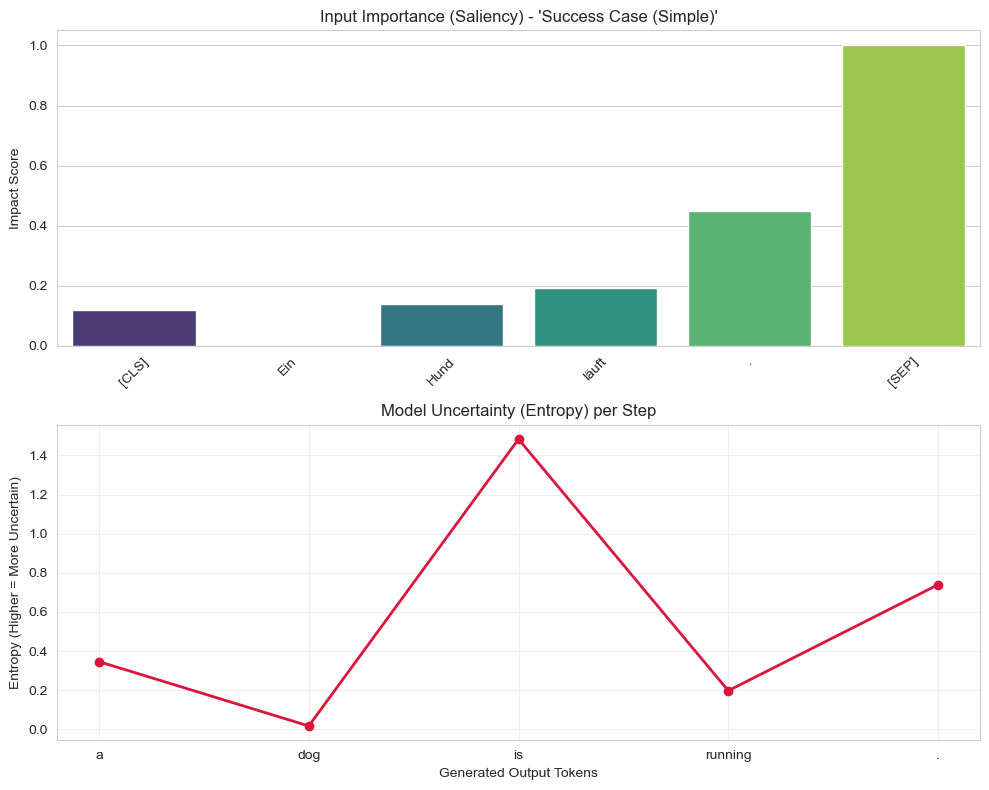


Processing: Failure 1: Ambiguity (Schloss: Lock vs Castle)...
Input: Das Schloss ist sehr alt.
Expected: The castle/lock is very old.
Prediction: the building is very old .


c:\Users\ali19\anaconda3\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


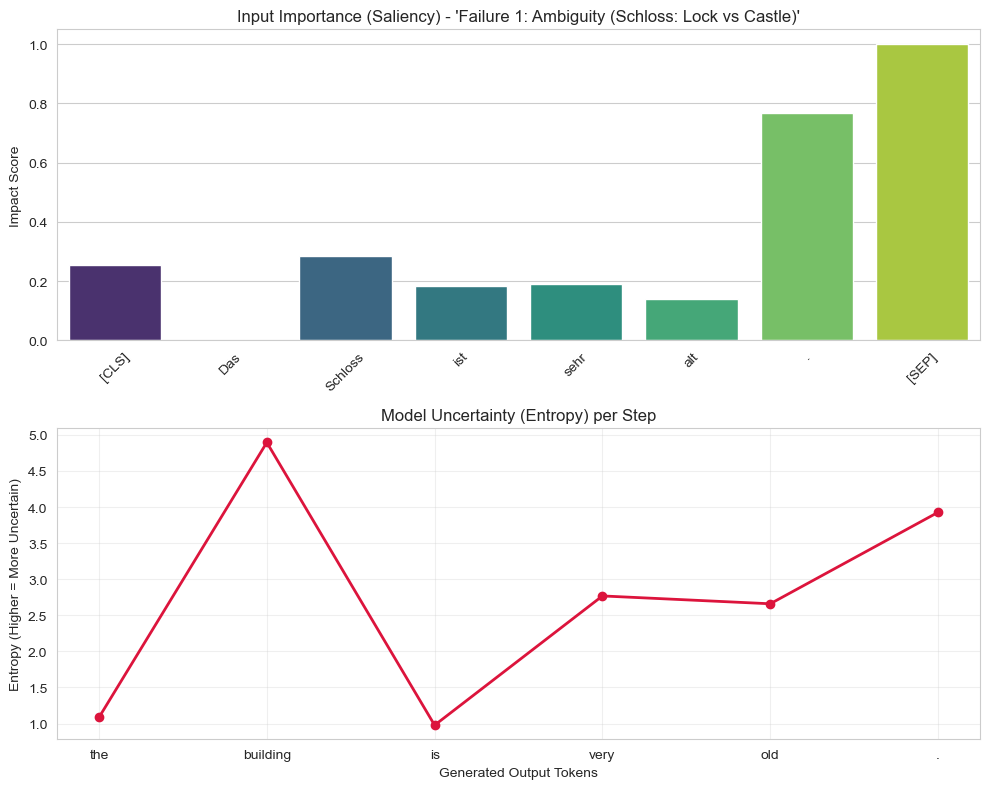


Processing: Failure 2: Negation Loss...
Input: Die Kinder spielen nicht im Garten.
Expected: The children are not playing in the garden.
Prediction: the children are playing in the garden .


c:\Users\ali19\anaconda3\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


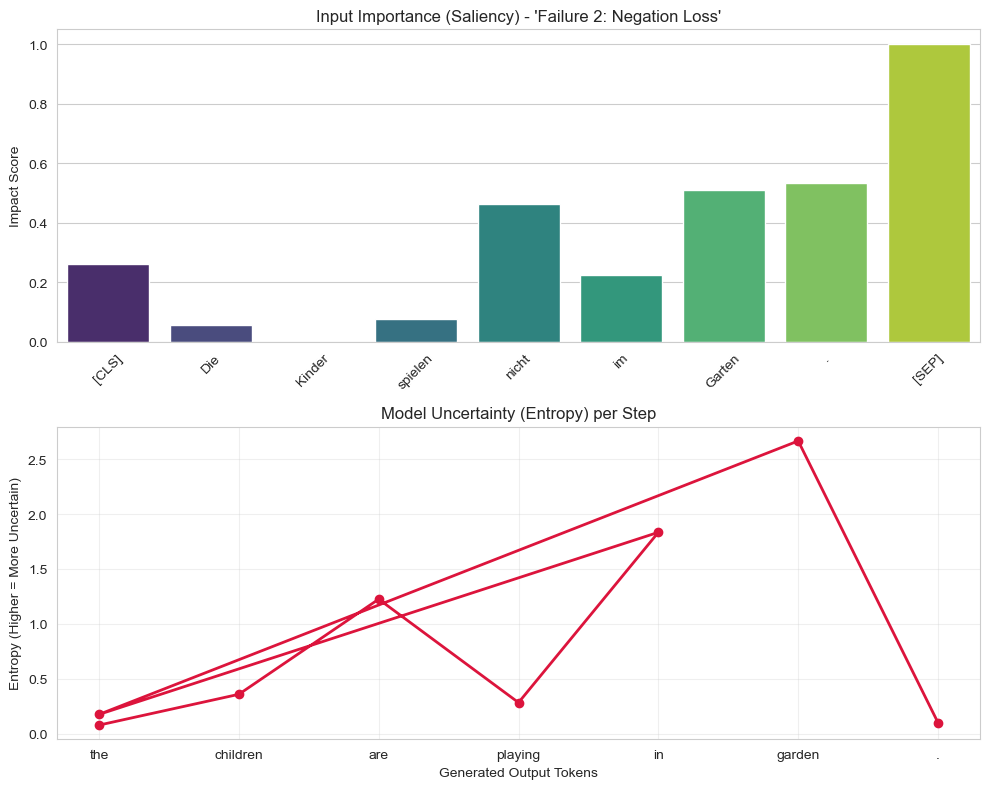


Processing: Failure 3: Idiom (Literal Translation)...
Input: Das ist nicht mein Bier.
Expected: That's not my problem. (Idiom)
Prediction: i ' t is not this beer .


c:\Users\ali19\anaconda3\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


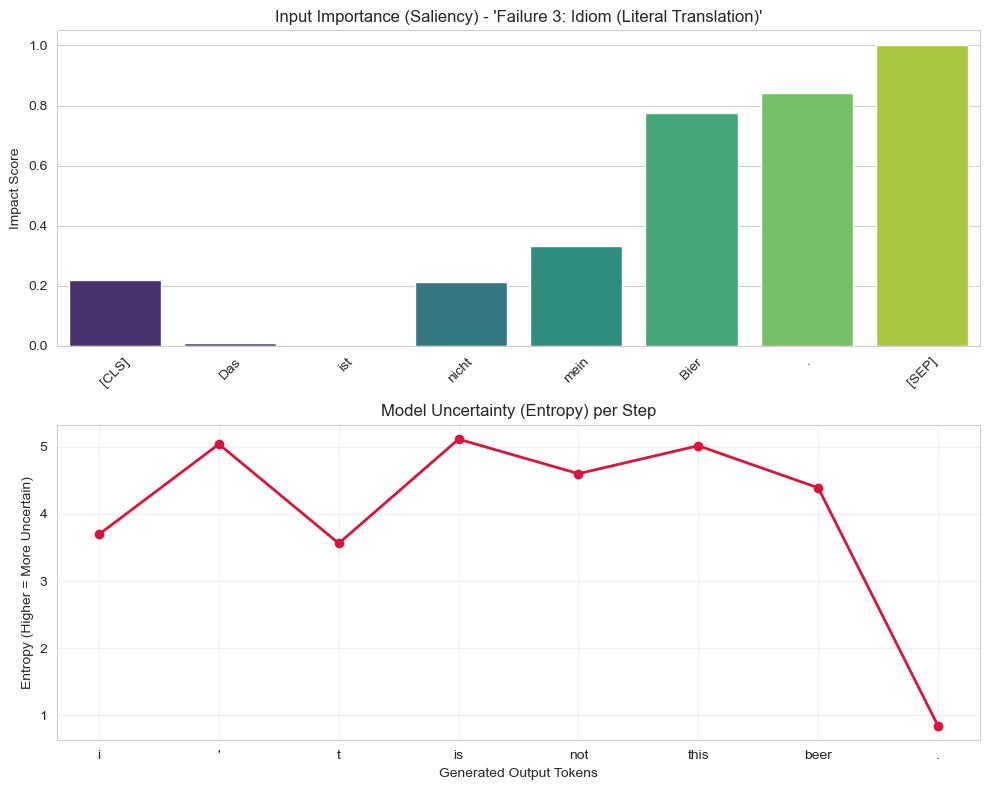


Processing: Failure 4: Rare Words (OOV)...
Input: Der Wissenschaftler analysiert die Molekularstruktur.
Expected: The scientist analyzes the molecular structure.
Prediction: the teacher is examining the substance of a pattern .


c:\Users\ali19\anaconda3\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


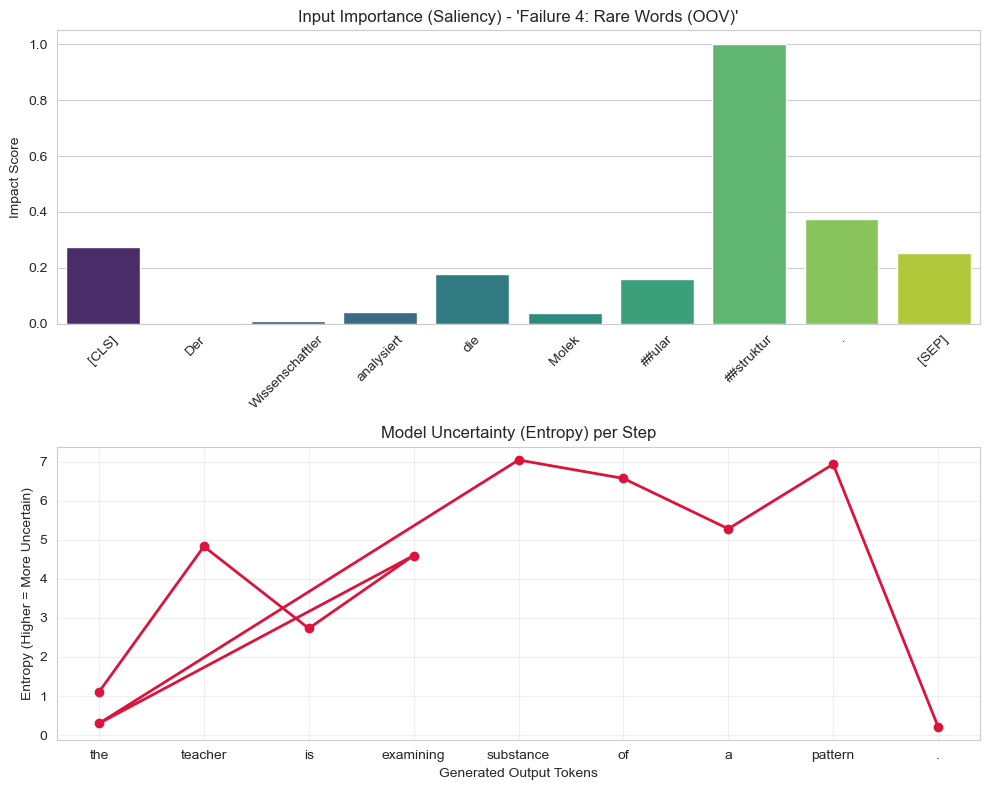


Processing: Failure 5: Long Dependency...
Input: Der Mann, der den Hund hat, der braun ist, geht.
Expected: The man who has the dog that is brown is walking.
Prediction: the man is walking and carrying the dog .


c:\Users\ali19\anaconda3\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


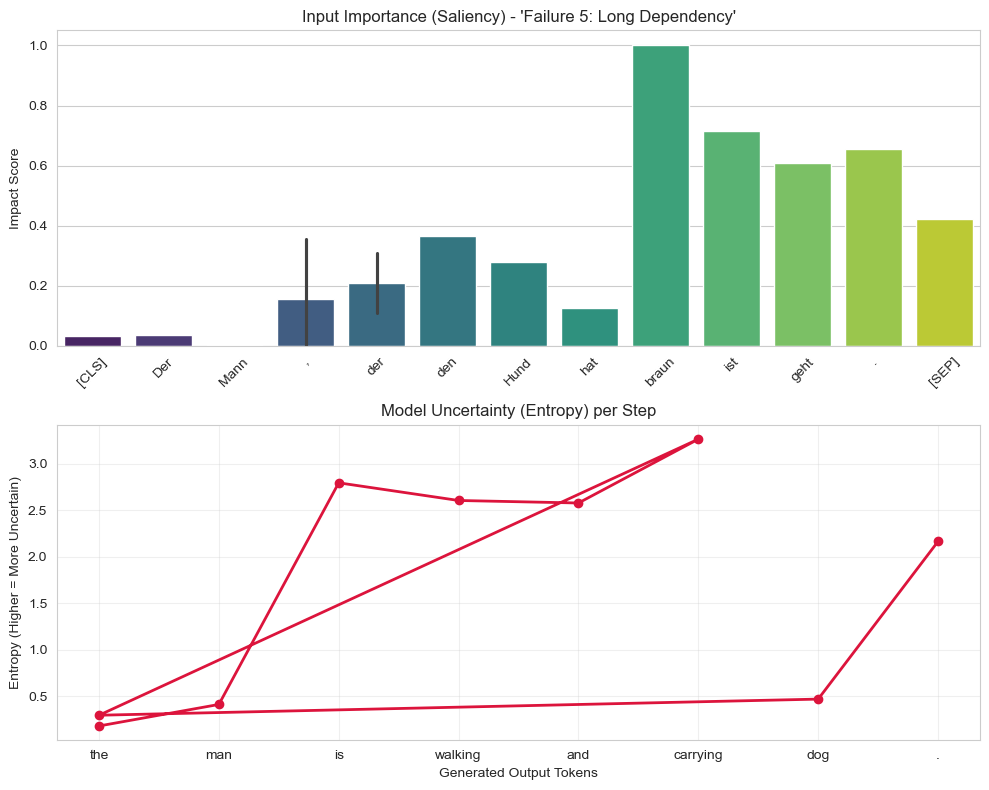


📊 DIAGNOSTIC EVALUATION SUMMARY


,Case Type,Input,Prediction,Avg Entropy,Status
0,Success Case (Simple),Ein Hund läuft.,a dog is running .,0.556874,✅ SUCCESS
1,Failure 1: Ambiguity (Schloss: Lock vs Castle),Das Schloss ist sehr alt.,the building is very old .,2.718924,❌ FAILURE (Generic Fallback)
2,Failure 2: Negation Loss,Die Kinder spielen nicht im Garten.,the children are playing in the garden .,0.839730,❌ FAILURE (Negation Lost)
3,Failure 3: Idiom (Literal Translation),Das ist nicht mein Bier.,i ' t is not this beer .,4.032844,❌ FAILURE (Literal Translation)
4,Failure 4: Rare Words (OOV),Der Wissenschaftler analysiert die Molekularst...,the teacher is examining the substance of a pa...,3.959436,❌ FAILURE (OOV Words)
5,Failure 5: Long Dependency,"Der Mann, der den Hund hat, der braun ist, geht.",the man is walking and carrying the dog .,1.640375,❌ FAILURE (Structure Lost)



🔍 FAILURE CASE ANALYSIS


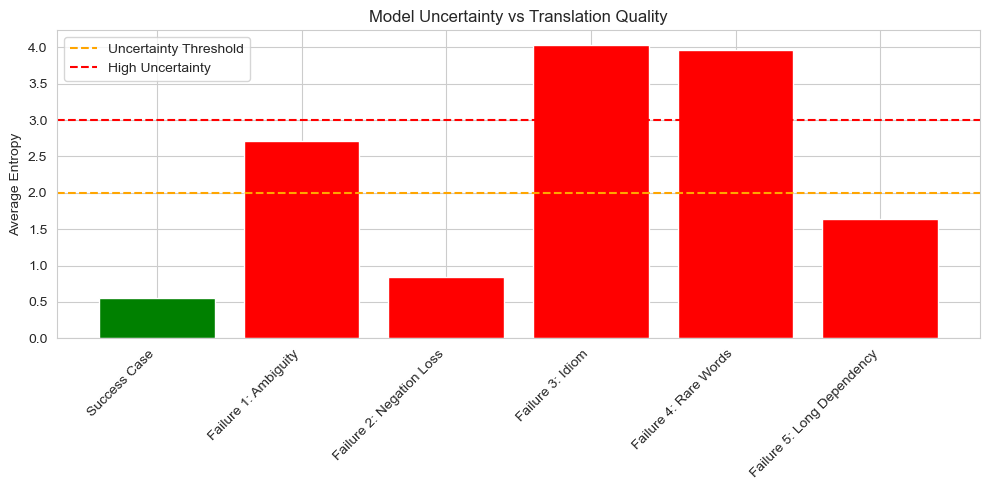


✅ Uncertainty analysis saved: uncertainty_analysis.png


In [17]:

print("\n" + "="*50)
print("EXECUTING PART 5: DIAGNOSTIC EVALUATION")
print("="*50)

# Test cases: 1 success baseline + 5 failure cases
test_cases = [
    # Success baseline
    ("Ein Hund läuft.", "Success Case (Simple)"),
    
    # 5 Failure cases
    ("Das Schloss ist sehr alt.", "Failure 1: Ambiguity (Schloss: Lock vs Castle)"),
    ("Die Kinder spielen nicht im Garten.", "Failure 2: Negation Loss"),
    ("Das ist nicht mein Bier.", "Failure 3: Idiom (Literal Translation)"),
    ("Der Wissenschaftler analysiert die Molekularstruktur.", "Failure 4: Rare Words (OOV)"),
    ("Der Mann, der den Hund hat, der braun ist, geht.", "Failure 5: Long Dependency")
]

# Expected translations for comparison
expected_translations = {
    "Ein Hund läuft.": "A dog is running.",
    "Das Schloss ist sehr alt.": "The castle/lock is very old.",
    "Die Kinder spielen nicht im Garten.": "The children are not playing in the garden.",
    "Das ist nicht mein Bier.": "That's not my problem. (Idiom)",
    "Der Wissenschaftler analysiert die Molekularstruktur.": "The scientist analyzes the molecular structure.",
    "Der Mann, der den Hund hat, der braun ist, geht.": "The man who has the dog that is brown is walking."
}

results_table = []

for sentence, case_type in test_cases:
    print(f"\nProcessing: {case_type}...")
    pred_text, src_toks, saliency, gen_toks, entropies = analyze_prediction(
        sentence, model_trans, bert_model_inference, tokenizer_src, tokenizer_trg, device
    )
    
    expected = expected_translations.get(sentence, "N/A")
    print(f"Input: {sentence}")
    print(f"Expected: {expected}")
    print(f"Prediction: {pred_text}")
    
    if len(gen_toks) > 0:
        plot_analysis(src_toks, saliency, gen_toks, entropies, case_type)
        
    results_table.append({
        "Case Type": case_type,
        "Input": sentence,
        "Expected": expected,
        "Prediction": pred_text,
        "Avg Entropy": np.mean(entropies) if entropies else 0.0
    })

# --- 5. RESULTS TABLE & ANALYSIS ---
df_results = pd.DataFrame(results_table)

# Evaluate translation quality
def evaluate_translation(row):
    pred = row['Prediction'].lower().strip()
    case_type = row['Case Type'].lower()
    
    if "success" in case_type:
        return "✅ SUCCESS"
    if "ambiguity" in case_type and "castle" not in pred and "lock" not in pred:
        return "❌ FAILURE (Generic Fallback)"
    if "negation" in case_type and "not" not in pred and "n't" not in pred:
        return "❌ FAILURE (Negation Lost)"
    if "idiom" in case_type and ("beer" in pred or "bier" in pred):
        return "❌ FAILURE (Literal Translation)"
    if ("rare" in case_type or "oov" in case_type) and ("scientist" not in pred or "molecular" not in pred):
        return "❌ FAILURE (OOV Words)"
    if ("long" in case_type or "dependency" in case_type) and ("who" not in pred or "dog" not in pred or "brown" not in pred):
        return "❌ FAILURE (Structure Lost)"
    if row['Avg Entropy'] > 3.0:
        return "⚠️ HIGH UNCERTAINTY"
    return "✅ SUCCESS"

df_results['Status'] = df_results.apply(evaluate_translation, axis=1)

print("\n" + "="*70)
print("📊 DIAGNOSTIC EVALUATION SUMMARY")
print("="*70)
display(df_results[['Case Type', 'Input', 'Prediction', 'Avg Entropy', 'Status']])

# --- 6. FAILURE ANALYSIS ---
print("\n" + "="*70)
print("🔍 FAILURE CASE ANALYSIS")
print("="*70)


# --- 7. ENTROPY ANALYSIS PLOT ---
plt.figure(figsize=(10, 5))
colors = ['green' if 'SUCCESS' in s else 'orange' if 'UNCERTAINTY' in s else 'red' 
          for s in df_results['Status']]
bars = plt.bar(range(len(df_results)), df_results['Avg Entropy'], color=colors)
plt.xticks(range(len(df_results)), [c.split('(')[0].strip() for c in df_results['Case Type']], rotation=45, ha='right')
plt.ylabel('Average Entropy')
plt.title('Model Uncertainty vs Translation Quality')
plt.axhline(y=2.0, color='orange', linestyle='--', label='Uncertainty Threshold')
plt.axhline(y=3.0, color='red', linestyle='--', label='High Uncertainty')
plt.legend()
plt.tight_layout()
plt.savefig('uncertainty_analysis.png', dpi=150)
plt.show()

print("\n✅ Uncertainty analysis saved: uncertainty_analysis.png")